## Wine Reviews 频繁模式与关联规则挖掘

[github地址](https://github.com/jlzz/jianlinzhen_datamining)

导入处理数据和绘图相关的包

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False

读取数据并查看前几条数据

In [2]:
df = pd.read_csv('Wine Reviews/winemag-data_first150k.csv')#.drop(0,axis=1)
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


删去包含空值的数据

In [3]:
df=df.dropna()

发现多出一列序号，删除；description属性信息处理较为复杂，去除

In [4]:
df = df.drop(df.columns.values.tolist()[0],axis=1)
df = df.drop(df.columns.values.tolist()[1],axis=1)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      39241 non-null  object 
 1   designation  39241 non-null  object 
 2   points       39241 non-null  int64  
 3   price        39241 non-null  float64
 4   province     39241 non-null  object 
 5   region_1     39241 non-null  object 
 6   region_2     39241 non-null  object 
 7   variety      39241 non-null  object 
 8   winery       39241 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 3.0+ MB


,country,designation,points,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,US,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,US,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


需要将连续数据points和price离散化处理。

可视化观察二者的数据分布。

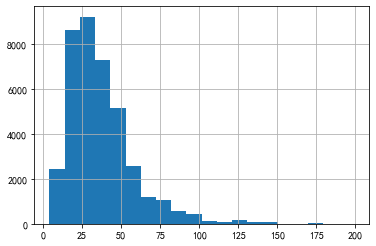

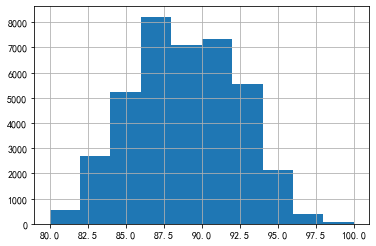

In [5]:
df['price'].loc[df['price']<200].hist(bins=20)
plt.show()
df['points'].hist()
plt.show()

In [6]:
bin = [0,75,80,85,90,95,100]
df['points'] = pd.cut(df['points'],bin)
df['points'] = df['points'].astype('str')
bin = [0,20,30,40,50,60,100,2500]
df['price'] = pd.cut(df['price'],bin)
df['price'] = df['price'].astype('str')
df.head()

,country,designation,points,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,"(95, 100]","(100, 2500]",California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,US,Special Selected Late Harvest,"(95, 100]","(60, 100]",California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,"(95, 100]","(60, 100]",Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,US,Silice,"(90, 95]","(60, 100]",Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,Gap's Crown Vineyard,"(90, 95]","(50, 60]",California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


构建Aprior算法

In [7]:
def createC1( dataSet ):
    """
    构建初始候选项集的列表，即所有候选项集只包含一个元素，
    C1是大小为1的所有候选项集的集合
    """
    C1 = []
    for transaction in np.array(dataSet):
        for item in transaction:
            if [item] not in C1:
                C1.append( [item] )
    C1.sort()
    return list(map( frozenset, C1 ))

def scanD( D, Ck, minSupport ):
    """
    计算Ck中的项集在数据集合D(记录或者transactions)中的支持度,
    返回满足最小支持度的项集的集合，和所有项集支持度信息的字典。
    """
    ssCnt = {}
    for tid in D:
        # 对于每一条transaction
        if Ck is not None:
            for can in Ck:
                # 对于每一个候选项集can，检查是否是transaction的一部分
                # 即该候选can是否得到transaction的支持
                if can.issubset( tid ):
                    ssCnt[ can ] = ssCnt.get( can, 0) + 1
    numItems = float( len( D ) )
    retList = []
    supportData = {}
    for key in ssCnt:
        # 每个项集的支持度
        support = ssCnt[ key ] / numItems
        
        # 将满足最小支持度的项集，加入retList
        if support >= minSupport:
            retList.insert( 0, key )
            
            # 汇总支持度数据
            supportData[ key ] = support
    return retList, supportData

# Aprior算法
def aprioriGen( Lk, k ):
    '''
    由初始候选项集的集合Lk生成新的生成候选项集，
    k表示生成的新项集中所含有的元素个数
    '''
    retList = []
    lenLk = len( Lk )
    for i in range( lenLk ):
        for j in range( i + 1, lenLk ):
            L1 = list( Lk[ i ] )[ : k - 2 ];
            L2 = list( Lk[ j ] )[ : k - 2 ];
            L1.sort();L2.sort()    
            if L1==L2:
                retList.append( Lk[ i ] | Lk[ j ] ) 
    return retList

def apriori( dataSet, minSupport = 0.5 ):
    # 构建初始候选项集C1
    C1 = createC1( dataSet )
    
    # 将dataSet集合化，以满足scanD的格式要求
    D =list( map( set, dataSet ))
    
    # 构建初始的频繁项集，即所有项集只有一个元素
    L1, suppData = scanD( D, C1, minSupport )
    L = [ L1 ]
    # 最初的L1中的每个项集含有一个元素，新生成的
    # 项集应该含有2个元素，所以 k=2
    k = 2
    
    while ( len( L[ k - 2 ] ) > 0 ):
        Ck = aprioriGen( L[ k - 2 ], k )
        Lk, supK = scanD( D, Ck, minSupport )
        
        # 将新的项集的支持度数据加入原来的总支持度字典中
        suppData.update( supK )
        
        # 将符合最小支持度要求的项集加入L
        L.append( Lk )
        
        # 新生成的项集中的元素个数应不断增加
        k += 1
    # 返回所有满足条件的频繁项集的列表，和所有候选项集的支持度信息
    return L, suppData

对于置信度大于0.1的模式进行进行挖掘并显示频繁项集

In [8]:
myDat = list(map(set,np.array(df)))
L, suppData = apriori(myDat, 0.1)
L

[[frozenset({'(80, 85]'}),
  frozenset({'(0, 20]'}),
  frozenset({'(85, 90]'}),
  frozenset({'(30, 40]'}),
  frozenset({'Washington'}),
  frozenset({'Columbia Valley'}),
  frozenset({'Central Coast'}),
  frozenset({'(20, 30]'}),
  frozenset({'Chardonnay'}),
  frozenset({'(40, 50]'}),
  frozenset({'(90, 95]'}),
  frozenset({'Pinot Noir'}),
  frozenset({'Sonoma'}),
  frozenset({'US'}),
  frozenset({'Napa'}),
  frozenset({'California'}),
  frozenset({'Cabernet Sauvignon'})],
 [frozenset({'(80, 85]', 'California'}),
  frozenset({'(80, 85]', 'US'}),
  frozenset({'(85, 90]', 'Central Coast'}),
  frozenset({'(0, 20]', 'California'}),
  frozenset({'(0, 20]', 'US'}),
  frozenset({'(0, 20]', '(85, 90]'}),
  frozenset({'(20, 30]', '(85, 90]'}),
  frozenset({'(30, 40]', 'California'}),
  frozenset({'(30, 40]', 'US'}),
  frozenset({'(85, 90]', 'California'}),
  frozenset({'(85, 90]', 'US'}),
  frozenset({'(30, 40]', '(85, 90]'}),
  frozenset({'Columbia Valley', 'US'}),
  frozenset({'US', 'Washingto

由于支持度大于0.1的频繁项集很多，取置信度大于0.8的进行分析

In [9]:
def select_conf(L,suppData,thredhold=0.8):
    confList = []
    for itemSet in L:
            for record in itemSet:
                if(len(record)>1): 
                    for i in record: 
                        tar = suppData[frozenset([i])]
                        bset = record - frozenset([i])
                        aset = suppData[record]
                        ret = suppData.get(bset)
                        try:
                            if suppData.get(bset):
                                con = aset/ret
                                if con > thredhold:
                                    confList.append([frozenset([i]),record,con])
                        except TypeError as e:
                            print(e)

    return confList

提升度相关性度量

In [10]:
def liftCheck(conList,suppData):
    liftList_true=[]
    liftList_no=[]
    liftList_false=[]
    for item in confList:
        score = suppData.get(item[1])/(suppData.get(item[0])*suppData.get(item[1]-item[0]))
        if score>1:
            liftList_true.append(item)
        if score<1:
            liftList_false.append(item)
        if score ==1:
            liftList_no.append(item)
    return liftList_true,liftList_no,liftList_false

根据提升度度量查看正相关的关联规则

In [11]:
confList = select_conf(L,suppData)
yes,no,false = liftCheck(confList,suppData)
yes

[[frozenset({'California'}),
  frozenset({'(80, 85]', 'California'}),
  0.8234507897934387],
 [frozenset({'Washington'}),
  frozenset({'Columbia Valley', 'Washington'}),
  1.0],
 [frozenset({'Columbia Valley'}),
  frozenset({'Columbia Valley', 'Washington'}),
  0.9449526298595231],
 [frozenset({'California'}),
  frozenset({'California', 'Chardonnay'}),
  0.8161389172625126],
 [frozenset({'California'}), frozenset({'California', 'Central Coast'}), 1.0],
 [frozenset({'California'}), frozenset({'California', 'Sonoma'}), 1.0],
 [frozenset({'California'}),
  frozenset({'Cabernet Sauvignon', 'California'}),
  0.826593137254902],
 [frozenset({'California'}), frozenset({'California', 'Napa'}), 1.0],
 [frozenset({'California'}),
  frozenset({'(80, 85]', 'California', 'US'}),
  0.8234507897934387],
 [frozenset({'California'}),
  frozenset({'(85, 90]', 'California', 'Central Coast'}),
  1.0],
 [frozenset({'Washington'}),
  frozenset({'Columbia Valley', 'US', 'Washington'}),
  1.0],
 [frozenset({'

全置信度和最大置信度计算

In [12]:

def all_confidence(conList,suppData):
    result = []
    for item in confList:
        score = suppData.get(item[1])/max(suppData.get(item[0]),suppData.get(item[1]-item[0]))
        result.append([score,item])
    return result

def max_confidence(conList,suppData):
    result = []
    for item in confList:
        score = suppData.get(item[1])/min(suppData.get(item[0]),suppData.get(item[1]-item[0]))
        result.append([score,item])
    return result

全置信度大于0.8的关联关系展示

In [13]:
def selsct_confidence(conf,delta,conf_str):
    for item in conf:
        if item[0] >= delta:
            print(conf_str,str(item[0]),item[1])
all_conf = all_confidence(yes,suppData)
selsct_confidence(all_conf,0.8,'全置信度')

全置信度 0.9449526298595231 [frozenset({'Washington'}), frozenset({'Washington', 'Columbia Valley'}), 1.0]
全置信度 0.9449526298595231 [frozenset({'Columbia Valley'}), frozenset({'Washington', 'Columbia Valley'}), 0.9449526298595231]
全置信度 0.9449526298595231 [frozenset({'Washington'}), frozenset({'US', 'Washington', 'Columbia Valley'}), 1.0]
全置信度 0.9449526298595231 [frozenset({'Columbia Valley'}), frozenset({'US', 'Washington', 'Columbia Valley'}), 0.9449526298595231]


最大置信度大于0.9的关联关系展示

In [14]:
max_conf = max_confidence(yes,suppData)
selsct_confidence(max_conf,0.9,'最大置信度')

最大置信度 1.0 [frozenset({'US'}), frozenset({'US', '(80, 85]'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset({'(0, 20]', 'US'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset({'US', '(30, 40]'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset({'US', '(85, 90]'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset({'US', 'Columbia Valley'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset({'US', 'Washington'}), 1.0]
最大置信度 1.0 [frozenset({'Washington'}), frozenset({'Washington', 'Columbia Valley'}), 1.0]
最大置信度 1.0 [frozenset({'Columbia Valley'}), frozenset({'Washington', 'Columbia Valley'}), 0.9449526298595231]
最大置信度 1.0 [frozenset({'California'}), frozenset({'Central Coast', 'California'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset({'US', 'Central Coast'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset({'(20, 30]', 'US'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset({'US', 'Chardonnay'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset({'(40, 50]', 'US'}), 1.0]
最大置信度 1.0 [frozenset({'US'}), frozenset(

计算不平衡比IR

In [15]:
def cal_ir(conList,suppData):
    result = []
    for item in confList:
        score = abs(suppData.get(item[0]) - suppData.get(item[1]-item[0])) / (suppData.get(item[0])+suppData.get(item[1]-item[0]) - suppData.get(item[1]))
        result.append([score,item[0],item[1]-item[0]])
    return result

In [16]:
IR = cal_ir(yes,suppData)
def bigger_ir(conf,delta1,delta2,conf_str):
    for item in conf:
        if item[0] > delta1 and  item[0] < delta2:
            print(conf_str,str(item[0]),item[1],item[2])
bigger_ir(IR,0.4,0.6,'ir')

ir 0.4981269590479346 frozenset({'US'}) frozenset({'(85, 90]'})


使用全置信度可以看到，产地Columbia Valley与城市Washington，国家US相关性较大；使用不平衡比分析可知，国家US与分数(85,90]平衡性较好